# Calculating Equilibrium FX

You can choose any currency pair you want.
You calculate the equilibrium FX for your local currency.

1. Indicate economic theories and models for calculating equilibrium FX.
2. Indicate macroeconomic variables used for calculating equilibrium FX.
3. Explain the connection between linear regression and Vector Error Correction (VEC).
4. Calculate equilibrium FX using VEC. You can use the Behavioural Equilibrium Exchange Rate (BEER) approach. Comment results.

### Indicate economic theories and models for calculating equilibrium FX.

The equilibirum foreign exchange (FX) rate is determined by the demand and supply of one currency given another. This value can be determined by the intersection between the demand curve and the supply curve of the currency pair.

![Equlibrium FX Rate](assets/equilibrium_fx.png)

In the example given by Khan Academy[1], we can see that the exchange rate between Peso and Euro is defined by:

- Different amount of Euros supplied at different rate of Peso per Euro, forming the supply curve
- Different amount of Euros demanded at different rate of Peso per Euro, forming the demand curve

The intersection of these two curves determine the equilibrium FX rate between Peso and Euro:

- A rate higher than the equilibrium will result in the supply of Euros to exceed the demand, applying a downward pressure in the rate, towards short-term equilibrium.
- A rate lower than the equilibirum will result in the demand of Eruos to exceed the supply, applying a upward pressure in the rate, towards short-term equilibirum.

## Indicate macroeconomic variables used for calculating equilibrium FX.

Macroeconomic variables which affects the demand or supply curve of the one currency, expressed in another will affect the equilibrium FX rate.

### Interest Rates

One such example is the interest rate of a country. When interest rates increases, savers from other countries will be encouraged to buy financial assets in that country[1]. That will require foreign savers to first buy the country's currency to buy the financial assets. This results in higher demand for the country's currency, resulting in increased exhange rate. 

Factors increasing interest rate can include the country's budget deficit. 

### Money Supply

The money supply of the country affects the supply of the currency directly. An increase in money supply results in a decrease in equilibrium FX[2].

One metrics that is available is M1 which directly measures physical currency and coin, demand deposits, travelers checks, other checkable deposits and negotiable order of withdrawal (NOW) accounts[3]. Basically, the most liquid form of money in a country.

### Inflation

Typically, a country with a consistently lower inflation rate exhibits a rising currency value, as its purchasing power increases relative to other currencies. [4]

### Industrial Production Index 

The Index of Industrial Production (IIP) has shown to be dependent on the exchange rate[5].

### Political Stability

Political stability of a country also affects the exchange rate positively. Investors are encouraged to invest in countries with higher political stability, resulting in higher demand for the currency[4].

## Explain the connection between linear regression and Vector Error Correction (VEC).

The Vector Auto-Regressive(VAR) model extends the linear regression model by allowing different processes to be grenerated from their mutual histories. 

![VAR](assets/var.png)

The VAR equation is produce the generating process based on previous period values, producing a short term forecasting result.  

The Vector Error Correction (VEC) model, also known as cointegration model, extends the VAR model. It introduces the long-term relationships between variables, through their cointegration.[6] 

![VECM](assets/vecm.png)

The VECM integrates information of the cointegration of the variables to allow them to return to long-run equilibirum. This can be seen from the PI term in the equation above. We can see that the VECM is a linear model, forming a linear relationship between the first difference of the result and the difference(s) of the previous results of the process, with it's constant and error terms.

## Calculate equilibrium FX using VEC. You can use the Behavioural Equilibrium Exchange Rate (BEER) approach. Comment results.

## Calculating USD/SGD

### Models

The VECM model will be used with the macroeconomic data below.

### Data Used

- USD/SGD (https://fred.stlouisfed.org/series/EXSIUS)
- US M1 (https://fred.stlouisfed.org/series/M1NS)
- SG M1 (https://secure.mas.gov.sg/msb-xml/Report.aspx?tableSetID=I...I..)
- US Inflation (https://fred.stlouisfed.org/series/FPCPITOTLZGUSA)
- SG Inflation (https://fred.stlouisfed.org/series/FPCPITOTLZGSGP)
- US Interest rate (https://fred.stlouisfed.org/series/FEDFUNDS)
- SG Interest rate (https://secure.mas.gov.sg/msb/InterestRatesOfBanksAndFinanceCompanies.aspx)

### Variables Used

- USD/SGD
- US M1 Increase (log)
- SG M1 Increase (log)
- Inflation differential (US-SG)
- Interest rate differential (US-SG)

In [98]:
library(quantmod)
library(readxl)
library(vars)
library(timeSeries)
library(urca)
library(tsDyn)

We will first download the data from the relevant sources. From the data source, we can observe that the maximum date range that has data for all the dataset is from Jan 1992 to Jan 2017. We will make use of the monthly data. 

For the dataset of M1_US and M1_SG, the dataset is of annual frequency. We will resample these data using linear interpolation to yield the monthly data. 

In [187]:
# Read data from CSV
USDSGD = read.table("data/USDSGD.csv", header=TRUE, sep = ",", colClasses = c("Date", "numeric"))
INTEREST_SG = read.table("data/INTEREST-SG.csv", header=TRUE, sep = ",", colClasses = c("Date", "numeric"))
INTEREST_US = read.table("data/INTEREST-US.csv", header=TRUE, sep = ",", colClasses = c("Date", "numeric"))
M1_SG = read.table("data/M1-SG.csv", header=TRUE, sep = ",", colClasses = c("Date", "numeric"))
M1_US = read.table("data/M1-US.csv", header=TRUE, sep = ",", colClasses = c("Date", "numeric"))
INF_US = read.table("data/INFLATION-US.csv", header=TRUE, sep = ",", colClasses = c("Date", "numeric"))
INF_SG = read.table("data/INFLATION-SG.csv", header=TRUE, sep = ",", colClasses = c("Date", "numeric"))

In [193]:
# Date Range: Jan 1991 - Jan 2017
DATE_RANGE = "199101/201701"

# Convert to xts
usdsgd = xts(USDSGD, order.by = USDSGD$DATE, x=USDSGD$EXSIUS)
interest_us = xts(INTEREST_US, order.by = INTEREST_US$DATE, x=INTEREST_US$FEDFUNDS)
interest_sg = xts(INTEREST_SG,  order.by = INTEREST_SG$Month, x = INTEREST_SG$Prime.Lending.Rate)
m1_us = xts(M1_US, order.by = M1_US$DATE, x=M1_US$M1)
m1_sg = xts(M1_SG, order.by = M1_SG$Month, x=M1_SG$S..MILLION)
inf_us = xts(INF_US, order.by = INF_US$DATE, x=INF_US$FPCPITOTLZGUSA)
inf_sg = xts(INF_SG, order.by = INF_SG$DATE, x=INF_SG$FPCPITOTLZGSGP)

# Resampling m1 to daily before converting to monthly data
seq_daily = seq(as.Date("1991-01-01"), as.Date(end(data), frac = 1), by = "day")
m1_us_daily = na.approx(m1_us, x = as.Date, xout = seq_daily)
m1_sg_daily = na.approx(m1_sg, x = as.Date, xout = seq_daily)
m1_us_monthly = merge(data, m1_us_daily, join = "left")
m1_us_monthly_pct = monthlyReturn(m1_us_monthly$m1_us_daily, type = "log")
m1_sg_monthly = merge(data, m1_sg_daily, join = "left")
m1_sg_monthly_pct = monthlyReturn(m1_sg_monthly$m1_sg_daily, type = "log")
data = merge(usdsgd[DATE_RANGE], m1_us_monthly_pct[DATE_RANGE], join = "left")
data = merge(data, m1_sg_monthly_pct[DATE_RANGE], join = "left")

# Interpolating inflation to monthly range
seq_monthly = seq(as.Date(start(data)), as.Date(end(data), frac = 1), by = "month")
inf_us_monthly = na.approx(inf_us, x = as.Date, xout = seq_monthly)
inf_sg_monthly = na.approx(inf_sg, x = as.Date, xout = seq_monthly)
# data = merge(data, inf_us_monthly[DATE_RANGE], join = "left")
# data = merge(data, inf_sg_monthly[DATE_RANGE], join = "left")

# Fill in any missing values in case we miss them
data = na.approx(data)

# Calculate interest rate & inflation rate differential
INT_DIFF = interest_us[DATE_RANGE] - interest_sg[DATE_RANGE]
INF_DIFF = inf_us_monthly[DATE_RANGE] - inf_sg_monthly[DATE_RANGE]
data = merge(data, INT_DIFF[DATE_RANGE], join = "left")
data = merge(data, INF_DIFF[DATE_RANGE], join = "left")

# Renaming columns
names(data) = c("USDSGD", "M1_INC_US", "M1_INC_SG", "INT_DIFF", "INF_DIFF")

# Show data after transformation
head(data)
nrow(data)

           USDSGD    M1_INC_US    M1_INC_SG INT_DIFF  INF_DIFF
1991-01-01 1.7455  0.000000000  0.000000000    -0.54 0.8092622
1991-02-01 1.7180  0.001516092  0.008959708    -1.18 0.8055665
1991-03-01 1.7589  0.004397424 -0.002767862    -1.31 0.8022285
1991-04-01 1.7688  0.014311606 -0.018541698    -1.52 0.7985328
1991-05-01 1.7688 -0.003334098  0.003669354    -1.65 0.7949563
1991-06-01 1.7782  0.006943358 -0.005656008    -1.81 0.7912607

[1] 313

Once the data has been transformed to the xts series, we can now plot the all the different dataset. 

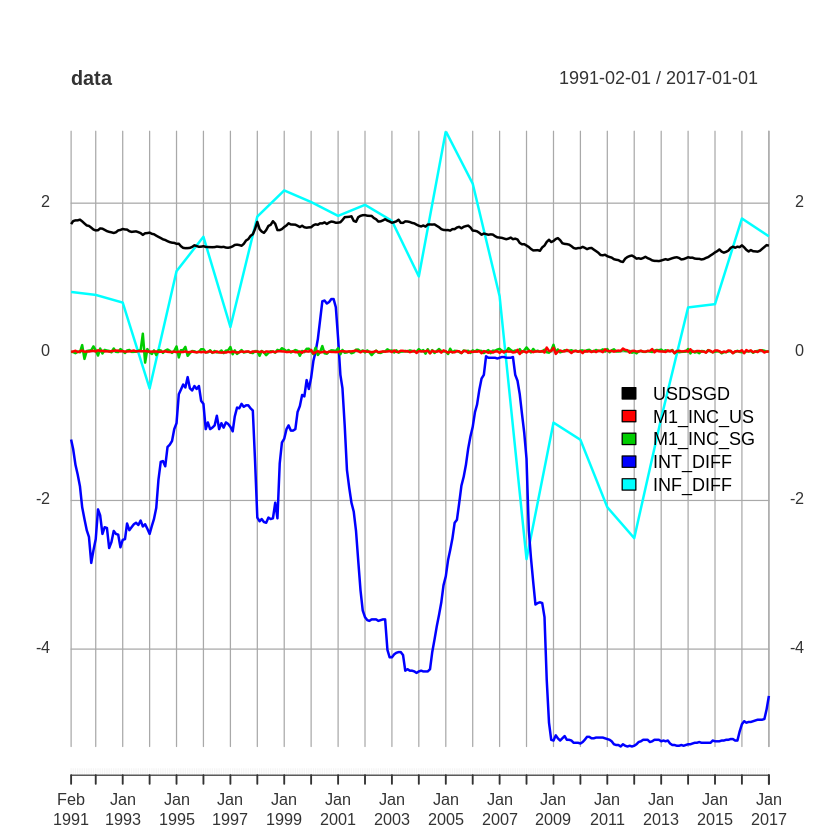

In [186]:
# Plot the data
plot(data, legend.loc = "right")

In [188]:
# Print correlation of the data
cor(data)

,USDSGD,M1_INC_US,M1_INC_SG,INT_DIFF,INF_DIFF
USDSGD,1.0000000,-0.12923933,-0.041475697,0.497684576,0.6454498
M1_INC_US,-0.1292393,1.00000000,0.072252470,-0.308143046,-0.2167271
M1_INC_SG,-0.0414757,0.07225247,1.000000000,-0.003533487,-0.1081419
INT_DIFF,0.4976846,-0.30814305,-0.003533487,1.000000000,0.4237391
INF_DIFF,0.6454498,-0.21672710,-0.108141863,0.423739134,1.0000000


From the correlation table, we can see that the exchange rate (USDSGD) is most highly correlated to the inflation differential followed by the interest rate differential. It also has the least correlation to the M1 money supply of Singapore. 

In [189]:
# VAR 
VAR_model = VAR(data, lag.max=12, type = "none", ic = "AIC")
summary(VAR_model)


VAR Estimation Results:
Endogenous variables: USDSGD, M1_INC_US, M1_INC_SG, INT_DIFF, INF_DIFF 
Deterministic variables: none 
Sample size: 310 
Log Likelihood: 3198.1 
Roots of the characteristic polynomial:
0.9989 0.9816 0.9511 0.9511 0.5136 0.3817 0.3817 0.114 0.114 0.03086
Call:
VAR(y = data, type = "none", lag.max = 12, ic = "AIC")


Estimation results for equation USDSGD: 
USDSGD = USDSGD.l1 + M1_INC_US.l1 + M1_INC_SG.l1 + INT_DIFF.l1 + INF_DIFF.l1 + USDSGD.l2 + M1_INC_US.l2 + M1_INC_SG.l2 + INT_DIFF.l2 + INF_DIFF.l2 

              Estimate Std. Error t value Pr(>|t|)    
USDSGD.l1     1.251514   0.056469  22.163  < 2e-16 ***
M1_INC_US.l1  0.157608   0.113593   1.387   0.1663    
M1_INC_SG.l1  0.061030   0.043307   1.409   0.1598    
INT_DIFF.l1   0.003049   0.006924   0.440   0.6600    
INF_DIFF.l1   0.025011   0.012052   2.075   0.0388 *  
USDSGD.l2    -0.252847   0.056332  -4.489 1.02e-05 ***
M1_INC_US.l2  0.117548   0.112881   1.041   0.2986    
M1_INC_SG.l2 -0.007003   0.0

Using a basic VAR model, we can see that the significant coefficients for the equation is:

- Interest rate differential
- M1 of US

We can also note that there is a total of 300 degree of freedom. This number is way too high as there are only 313 rows on the dataset. We will need to estimate with fewer variables later.

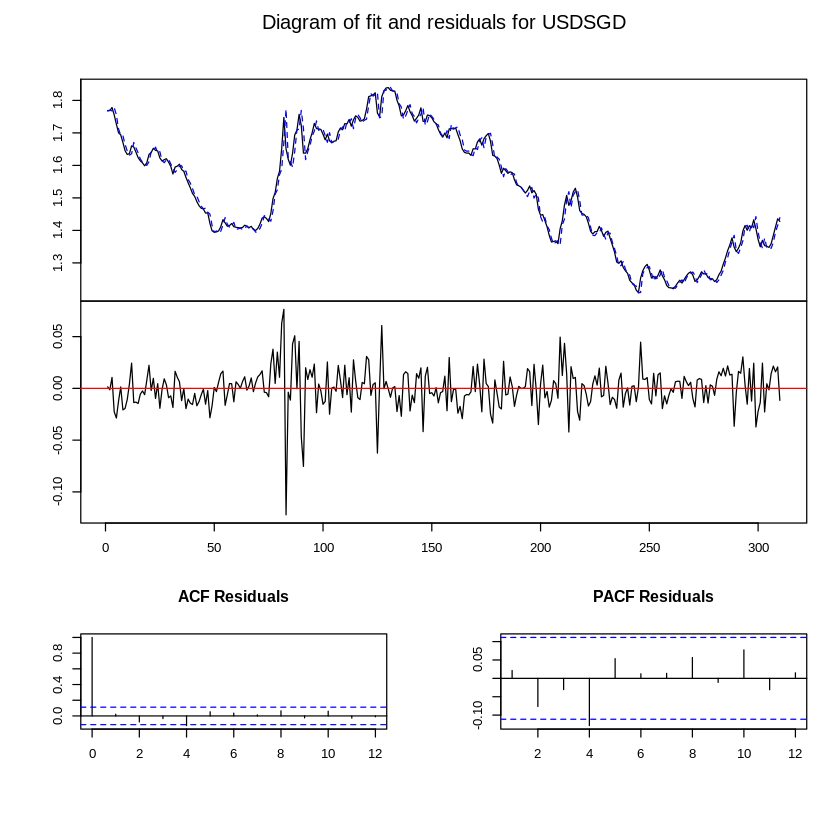

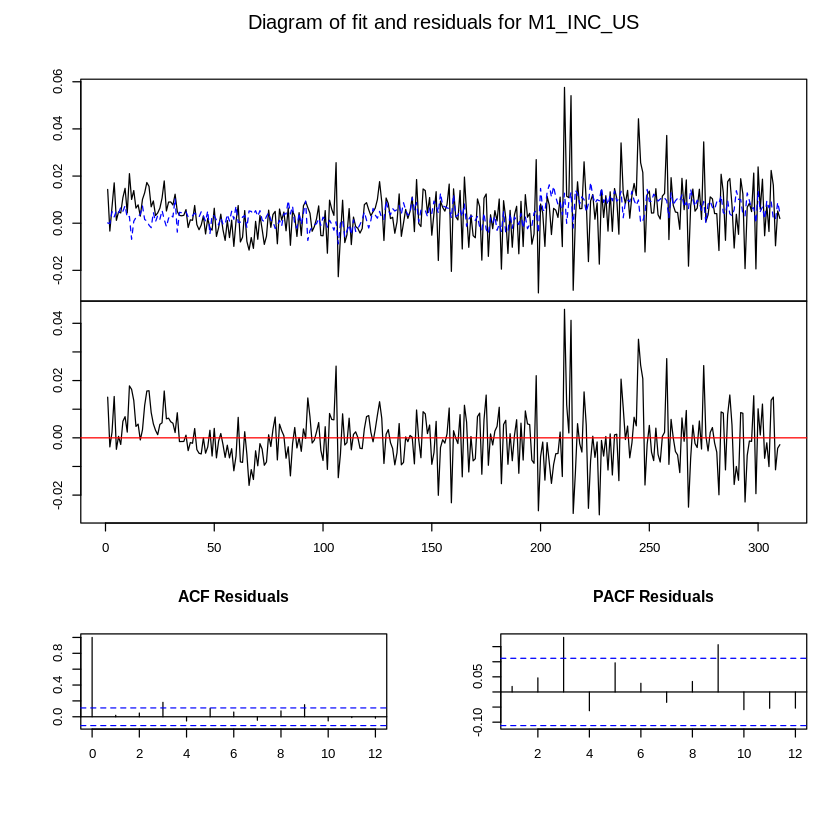

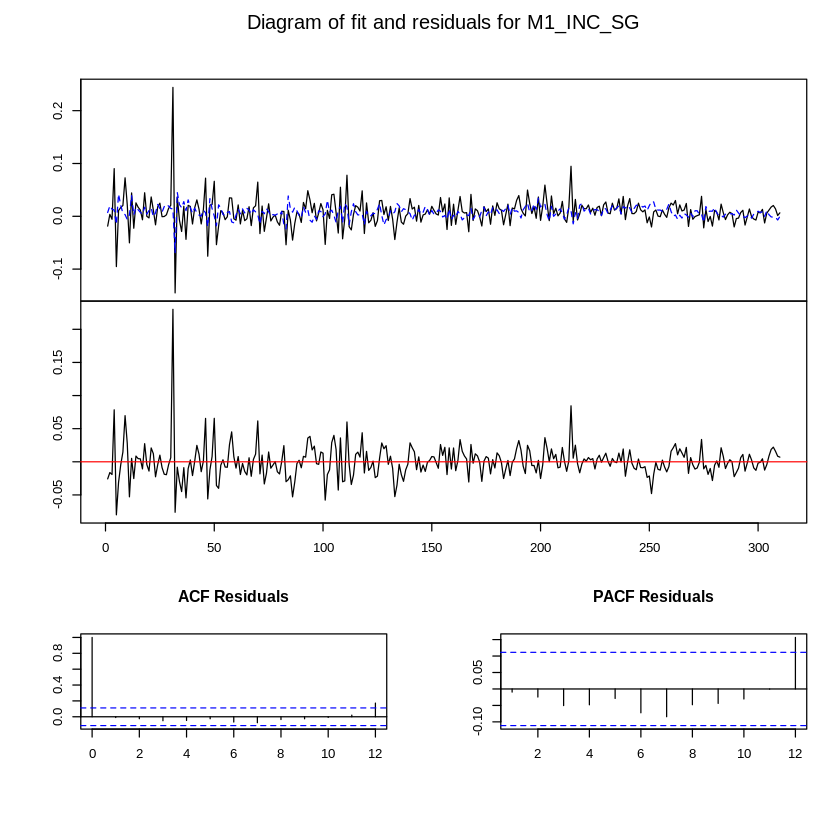

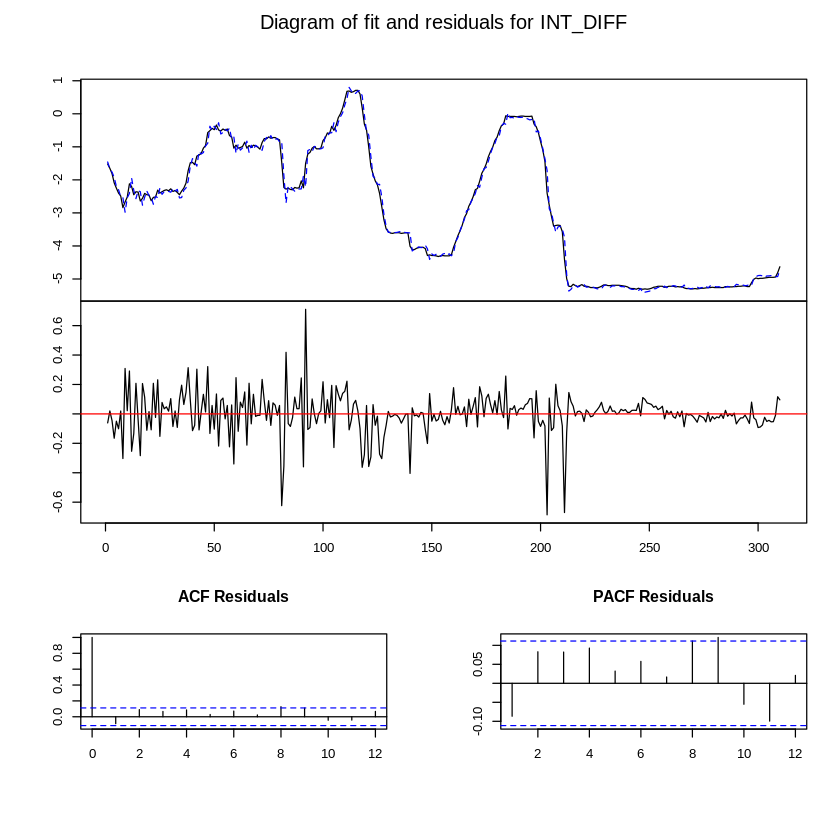

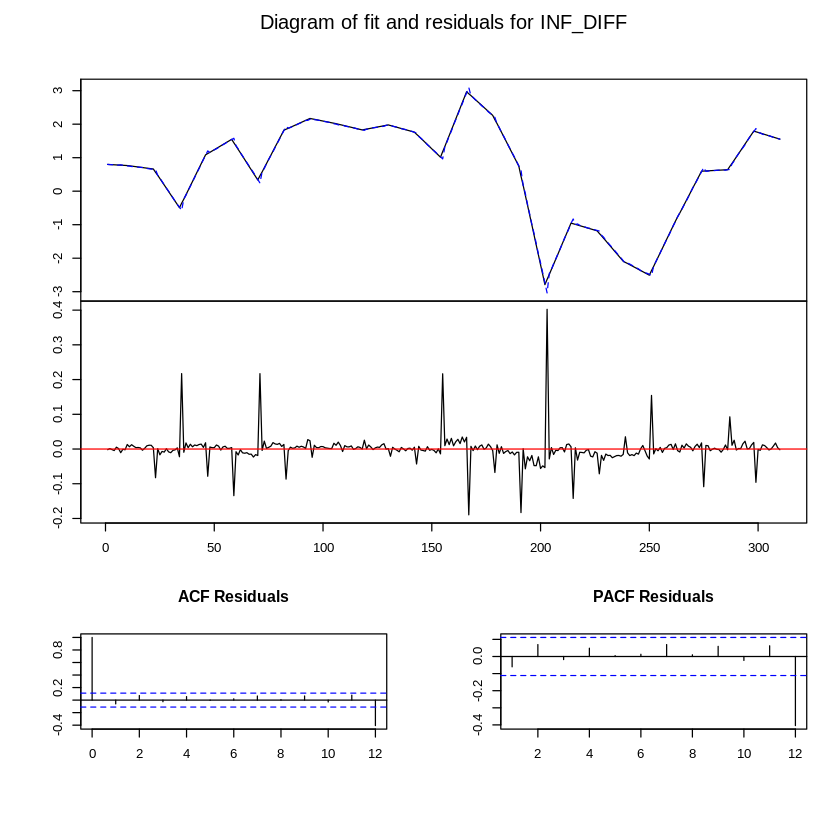

In [190]:
plot(VAR_model)

The ACF and PACF of the USDSGD dataset seemed to be stationary and are made up of white noises.

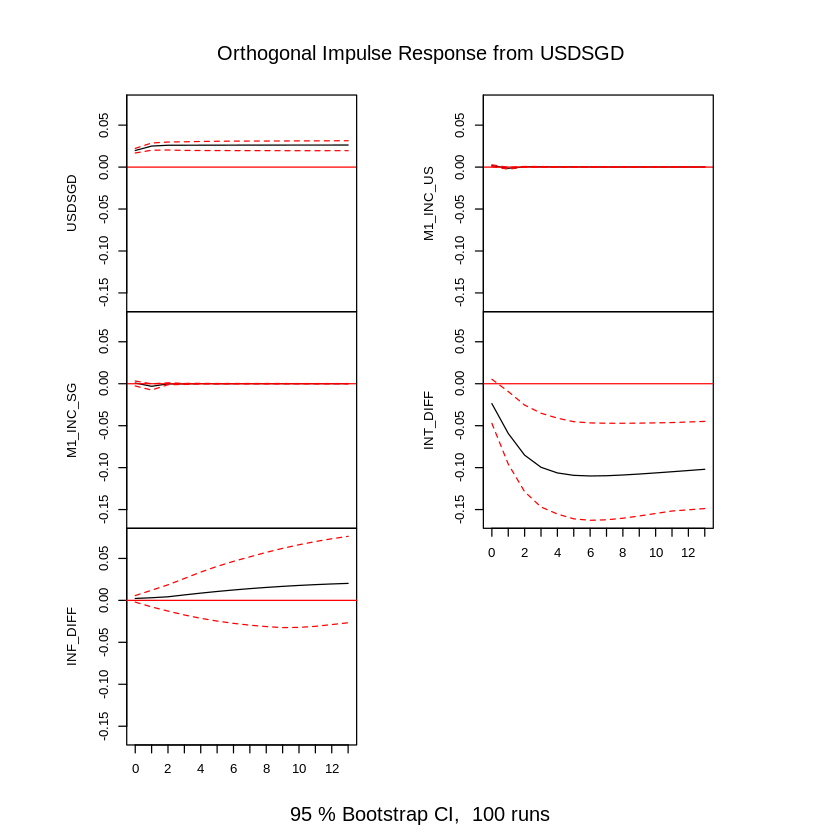

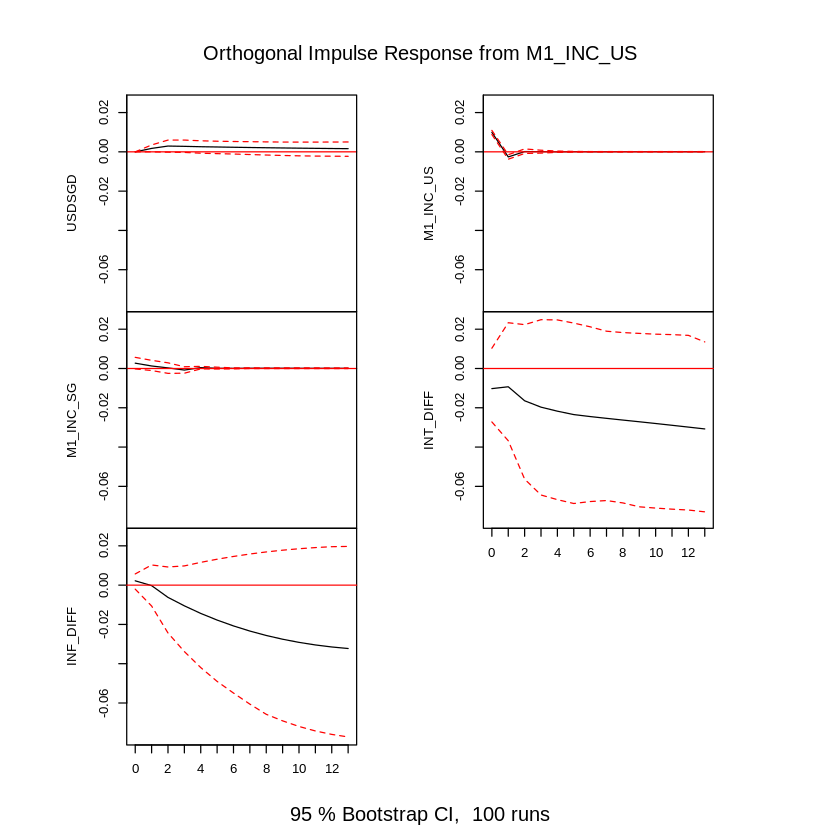

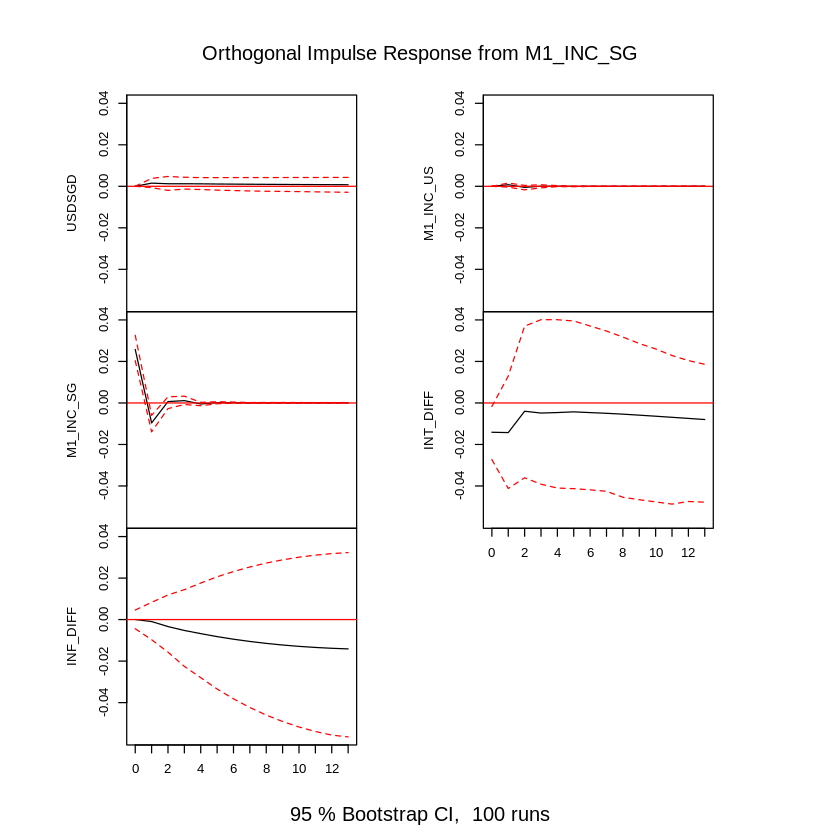

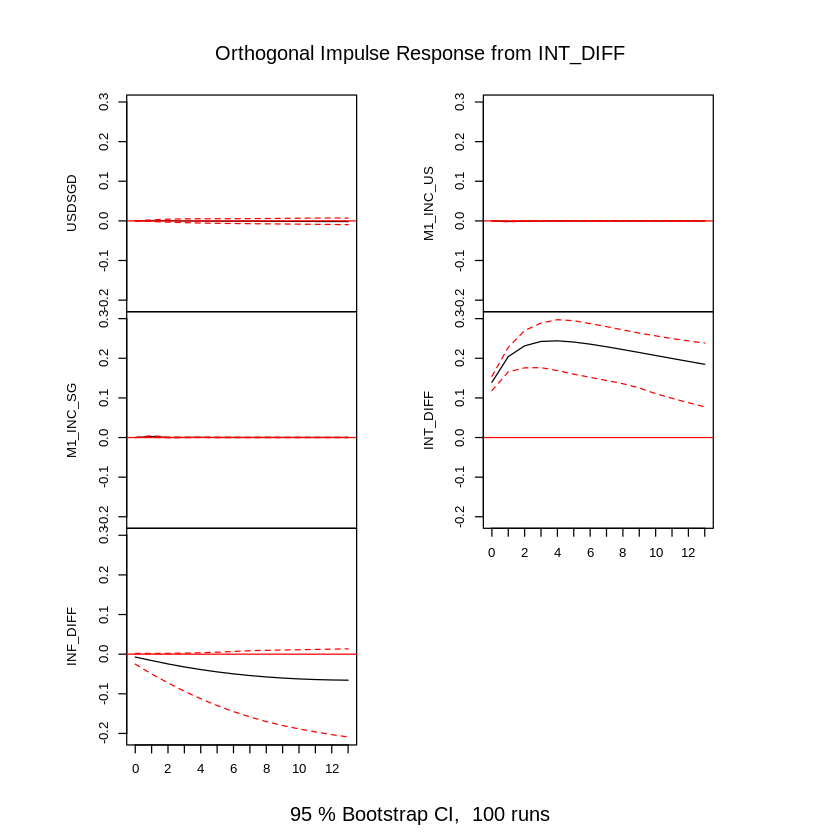

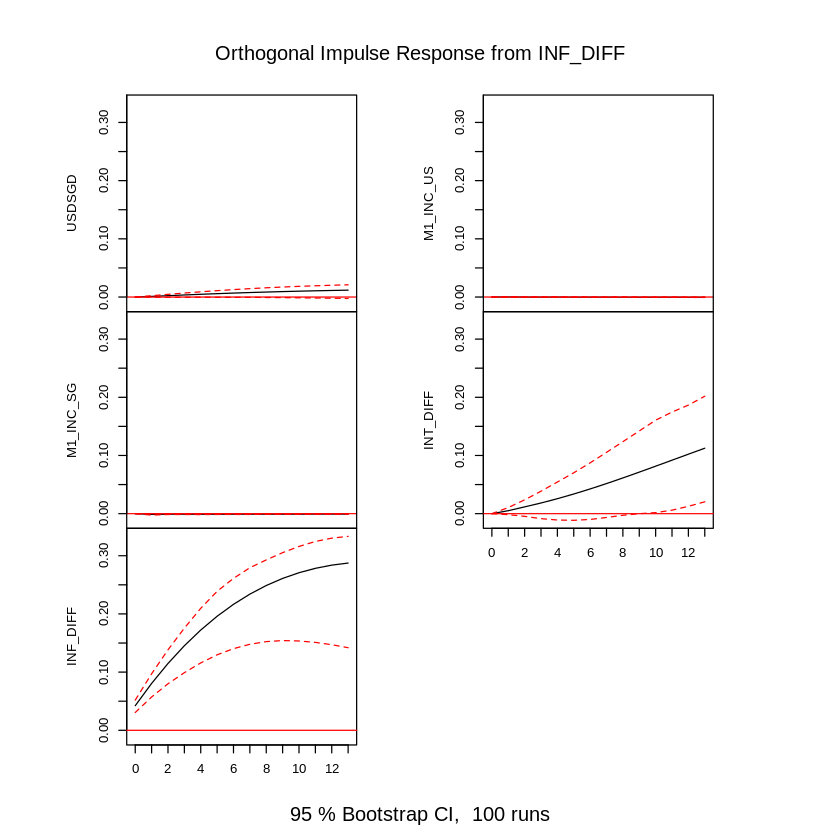

In [139]:
# compute and plot the impulse response functions
VAR_irf = irf(VAR_model, n.ahead = 13,boot = TRUE, ci = 0.95)
plot(VAR_irf)

From the impulse function of USDSGD, we can see that both M1_US and M1_SG quickly return to the mean, interest rate differential also seemed to be returning to the mean, but very slowly. 

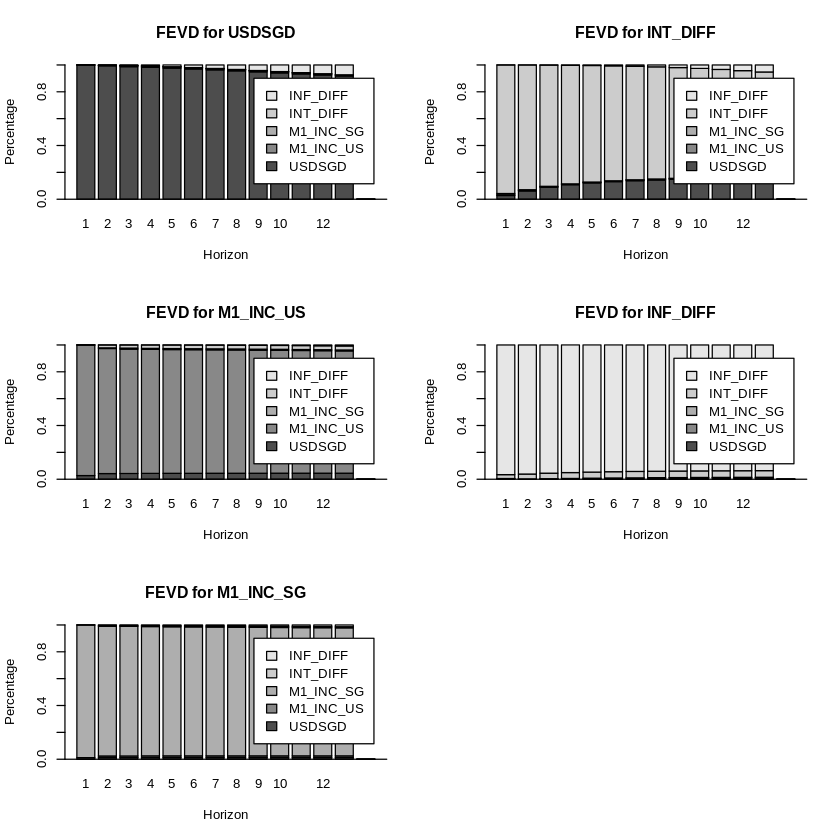

In [127]:
# compute and plot the forecast error variance decomposition
VAR_fevd <- fevd(VAR_model,n.ahead = 13)
plot(VAR_fevd)

Looking at the forecast error variance decomposition, we can see that the USDSGD does not have components of other variables in the short term but seemed to be explained by the interest rate differential in the long term. We can make use of this information to generate a more parsimonious model.

In [131]:
jotest1=ca.jo(data, type="eigen", K=9, ecdet="none", spec="longrun")
summary(jotest1)


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , with linear trend 

Eigenvalues (lambda):
[1] 0.183749082 0.083705728 0.061071661 0.034668610 0.009592389

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 4 |  2.92  6.50  8.18 11.65
r <= 3 | 10.69 12.91 14.90 19.19
r <= 2 | 19.09 18.90 21.07 25.75
r <= 1 | 26.49 24.78 27.14 32.14
r = 0  | 61.52 30.84 33.32 38.78

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                 USDSGD.l9 M1_INC_US.l9 M1_INC_SG.l9 INT_DIFF.l9  INF_DIFF.l9
USDSGD.l9      1.000000000   1.00000000   1.00000000     1.00000  1.000000000
M1_INC_US.l9   5.569691818 -72.99149460  -0.30710287  2396.09226  5.538829262
M1_INC_SG.l9 -67.074770837   3.75049801   1.08636131  -515.22389  0.707298625
INT_DIFF.l9    0.009467883  -0.07750398  -0.05346909    13.33348  0.045939215
INF_DIFF.l9   -0.223331885  -0.2059625

In [194]:
jotest2=ca.jo(data, type="trace", K=9, ecdet="none", spec="longrun")
summary(jotest2)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 0.182334987 0.084197049 0.059799870 0.034633135 0.009283369

Values of teststatistic and critical values of test:

           test 10pct  5pct  1pct
r <= 4 |   2.84  6.50  8.18 11.65
r <= 3 |  13.55 15.66 17.95 23.52
r <= 2 |  32.30 28.71 31.52 37.22
r <= 1 |  59.03 45.23 48.28 55.43
r = 0  | 120.23 66.49 70.60 78.87

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                 USDSGD.l9 M1_INC_US.l9 M1_INC_SG.l9 INT_DIFF.l9  INF_DIFF.l9
USDSGD.l9      1.000000000   1.00000000   1.00000000     1.00000  1.000000000
M1_INC_US.l9   7.052974270 -70.91007192   1.03908196  7819.06677  4.506471954
M1_INC_SG.l9 -67.122919617   3.11734181   1.24902002 -1726.33262  0.660890598
INT_DIFF.l9    0.008493893  -0.07830929  -0.05113518    44.34699  0.047017679
INF_DIFF.l9   -0.221603913  -0.20428627  -0.10330311   -46

Both Johansen-Procedure test shows that we can use r = 2.

In [196]:
fit = VECM(data, 3, r = 2, include = "const",estim = "ML", LRinclude = "none")
summary(fit)

#############
###Model VECM 
#############
Full sample size: 313 	End sample size: 309
Number of variables: 5 	Number of estimated slope parameters 90
AIC -10631.59 	BIC -10273.19 	SSR 6.834194
Cointegrating vector (estimated by ML):
          USDSGD    M1_INC_US  M1_INC_SG    INT_DIFF     INF_DIFF
r1  1.000000e+00 3.552714e-15 -77.429157 0.018740912 -0.281552410
r2 -5.269906e-19 1.000000e+00  -1.016069 0.001882071 -0.001415143


                   ECT1               ECT2               Intercept          
Equation USDSGD    -0.0086(0.0037)*   0.5421(0.2829).    0.0102(0.0053).    
Equation M1_INC_US 0.0140(0.0019)***  -1.0870(0.1426)*** -0.0204(0.0027)*** 
Equation M1_INC_SG 0.0133(0.0049)**   0.5746(0.3731)     -0.0035(0.0070)    
Equation INT_DIFF  -0.0500(0.0270).   3.0332(2.0597)     0.0600(0.0387)     
Equation INF_DIFF  0.0290(0.0080)***  -2.0541(0.6090)*** -0.0400(0.0114)*** 
                   USDSGD -1           M1_INC_US -1        M1_INC_SG -1       
Equation USDSGD    0.2623

In [197]:
predict(fit, n.ahead=3)

,USDSGD,M1_INC_US,M1_INC_SG,INT_DIFF,INF_DIFF
314,1.422764,0.000365743,-0.004518124,-4.534573,1.532782
315,1.420645,0.005404270,0.003997137,-4.459303,1.526594
316,1.418958,0.003037646,0.005517923,-4.407052,1.520535


## VECM with fewer variables

Using the information above, we can create a more parsimonious model. It can be seen that the significant coefficients of the previous model is the interest rate differential and the M1 money supply of US.

In [240]:
data_simp = data$USDSGD
data_simp = merge(data_simp, data$INT_DIFF)
data_simp = merge(data_simp, data$M1_INC_US)

In [241]:
jotest3=ca.jo(data_simp, type="eigen", K=9, ecdet="none", spec="longrun")
summary(jotest3)


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , with linear trend 

Eigenvalues (lambda):
[1] 0.067385652 0.041820252 0.004837982

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 2 |  1.47  6.50  8.18 11.65
r <= 1 | 12.99 12.91 14.90 19.19
r = 0  | 21.21 18.90 21.07 25.75

Eigenvectors, normalised to first column:
(These are the cointegration relations)

               USDSGD.l9 INT_DIFF.l9 M1_INC_US.l9
USDSGD.l9      1.0000000    1.000000   1.00000000
INT_DIFF.l9    0.1800576   -0.159094   0.04458363
M1_INC_US.l9 193.9029368  -26.387258   2.29898383

Weights W:
(This is the loading matrix)

               USDSGD.l9  INT_DIFF.l9  M1_INC_US.l9
USDSGD.d    -0.001852385 -0.010897085 -0.0046122959
INT_DIFF.d   0.015492788  0.118265325 -0.0210486186
M1_INC_US.d -0.003589055  0.001925471 -0.0001587515


In [245]:
The Johansen-Procedure suggest to use r = 1

ERROR: Error in parse(text = x, srcfile = src): <text>:1:5: unexpected symbol
1: The Johansen
        ^


In [242]:
fit2 = VECM(data_simp, 2, r = 1, include = "const",estim = "ML", LRinclude = "none")
summary(fit2)

#############
###Model VECM 
#############
Full sample size: 313 	End sample size: 310
Number of variables: 3 	Number of estimated slope parameters 24
AIC -6488.479 	BIC -6391.328 	SSR 6.448042
Cointegrating vector (estimated by ML):
   USDSGD   INT_DIFF M1_INC_US
r1      1 -0.6478023 -356.7588


                   ECT                 Intercept           USDSGD -1         
Equation USDSGD    -0.0009(0.0007)     0.0009(0.0016)      0.2859(0.0573)*** 
Equation INT_DIFF  -0.0002(0.0048)     -0.0036(0.0119)     -1.0529(0.4187)*  
Equation M1_INC_US 0.0028(0.0003)***   -0.0052(0.0008)***  -0.0754(0.0286)** 
                   INT_DIFF -1         M1_INC_US -1        USDSGD -2          
Equation USDSGD    -0.0063(0.0078)     -0.1650(0.1817)     -0.0748(0.0582)    
Equation INT_DIFF  0.4365(0.0572)***   0.4367(1.3283)      0.1152(0.4258)     
Equation M1_INC_US -0.0126(0.0039)**   -0.2476(0.0908)**   -0.0200(0.0291)    
                   INT_DIFF -2        M1_INC_US -2       
Equation USDSGD 

## Conclusion

Using VECM we tend to face the curse of dimensionality as shown in the first example with 5 variables. Using the combinations of correlation & forecast error variance decompisition we may deduce a simpler model. The SSR for the first model improved from 6.834194 to 6.448042 and the number of coefficients to estimate reduced from 300 to 24 by using only three variables and lower r. 

We can also observe that the second model has great proportion of coefficients that are significant compared to the first model. 

While the AIC and BIC suffered when the dimensionality is reduced, we can attribute it to the overfiting of data when higher dimensions are used, and should still opt for the more parismonious model. 

In [251]:
# Last interest rate in the model
usdsgd["201701"]

# Actual interest rate to be forcasted
usdsgd["201702/201704"]

             [,1]
2017-01-01 1.4276

             [,1]
2017-02-01 1.4137
2017-03-01 1.4049
2017-04-01 1.3983

In [243]:
predict(fit2, n.ahead=3)

,USDSGD,INT_DIFF,M1_INC_US
314,1.422295,-4.525287,0.003174703
315,1.421568,-4.448128,0.007283518
316,1.421708,-4.398968,0.005159924


Using the second model, we can create a prediction of the quarter interest rate. We can see that the prediction is pretty close to the actual interest rate where it shows a downward trend from 1.4276. 

## References
[1] https://www.khanacademy.org/economics-finance-domain/ap-macroeconomics/every-graph-used-in-ap-macroeconomics/a/the-foreign-exchange-market-model

[2] https://eml.berkeley.edu/~obstfeld/182_sp06/c14.pdf

[3] https://www.investopedia.com/terms/m/m1.asp

[4] [https://www.investopedia.com/trading/factors-influence-exchange-rates/]

[5] https://www.researchgate.net/publication/228258887_Causal_Relationships_between_Industrial_Production_Interest_Rate_and_Exchange_Rate_Evidence_on_India

[6] https://stats.stackexchange.com/questions/77791/why-use-vector-error-correction-model

https://www.researchgate.net/publication/320372110_MODELING_AND_FORECASTING_EXCHANGE_RATES

https://homepage.univie.ac.at/robert.kunst/prog05bihawei.pdf